In [345]:
import os

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 70)
os.chdir('../')
import data 
import losses
os.chdir('notebooks')

2023-03-03 16:49:05.907541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions

In [3]:
def read_stations(path):
    stations_df = pd.read_parquet(path)
    stations_df['station_name'] = [data.strip_accents(col) for col in stations_df.station_name.astype(str)]
    stations_df = stations_df[['station_name','latitude','longitude']].drop_duplicates(subset = 'station_name')
    return stations_df                                                                  

In [4]:
def close_stations_difference(target, results, close_station_name, nearby_stations):

    df_target = target#[83296:127000].iloc[:-4]
    closed = df_target[close_station_name] == 0
    closed = closed.values

    #Target Values
    target_close = df_target[nearby_stations][closed]
    target_open = df_target[nearby_stations][~closed]

    metrics = {}
    for result in results:
        df_predicted = result#[83296:127000].iloc[:-4]
        predicted_close = df_predicted[nearby_stations][closed]
        predicted_open = df_predicted[nearby_stations][~closed]
        m_close, se_close = losses.stats(target_close, predicted_close, losses.sMAPE, bs_se = True)
        m_open, se_open = losses.stats(target_open, predicted_open, losses.sMAPE, bs_se = True)
        metrics[result.name] = {"All Open": "{:.2f} (\u00B1{:.2f})".format(m_open, se_open),
                                "One Close":"{:.2f} (\u00B1{:.2f})".format(m_close, se_close),
                                "Difference": "{:.2f}".format(m_open-m_close)}
        
    return pd.DataFrame(metrics).T

# Data

In [5]:
# Upload Target Data:
target = data.clean_data('../../data/transactions.parquet')
target = target.iloc[1064:,:-8]
filter_time = (target.index.hour > 5) & (target.index.hour < 22)
filtered_target = target[filter_time].loc['2018-08-01':'2020-03-15']
print( "Target Shape: {}".format(filtered_target.shape))

# Loading Results
experiments = ['1_lstm_None_lstm_predictions.parquet','2_lstm_mask_lstm_predictions.parquet',
               '3_lstm_dummy_lstm_predictions.parquet', '4_fnn_None_fnn_predictions.parquet', 
               '5_fnn_mask_fnn_predictions.parquet', '6_fnn_dummy_fnn_predictions.parquet',
               '7_cnn_None_cnn_predictions.parquet', '8_cnn_mask_cnn_predictions.parquet', 
               '9_cnn_dummy_cnn_predictions.parquet', 
               '10_transformer_None_transformer_predictions.parquet',
               '11_transformer_mask _transformer_predictions.parquet',
               '12_transformer_dummy_transformer_predictions.parquet', 
               '13_gnn_None_gnn_predictions.parquet', 
               '14_gnn_mask _gnn_predictions.parquet',
               '15_gnn_dummy_gnn_predictions.parquet']

filter_predictions = []

for i, exp in enumerate(experiments):
    df = pd.read_parquet('../outputs/{}'.format(exp))
    filter_time = (df.index.hour > 5) & (df.index.hour < 22)
    df = df[filter_time].loc['2018-08-01':'2020-03-15'] 
    df.name = exp[:11]
    names = exp.split("_")[1:3]
    df.model = names[0]
    df.closure_mode = names[1]
    filter_predictions.append(df)
    print("Experiment {} shape: {}".format(i+1, df.shape))

Target Shape: (37952, 147)
Experiment 1 shape: (37952, 147)
Experiment 2 shape: (37952, 147)
Experiment 3 shape: (37952, 147)
Experiment 4 shape: (37952, 147)
Experiment 5 shape: (37952, 147)
Experiment 6 shape: (37952, 147)
Experiment 7 shape: (37952, 147)
Experiment 8 shape: (37952, 147)
Experiment 9 shape: (37952, 147)
Experiment 10 shape: (37952, 147)
Experiment 11 shape: (37952, 147)
Experiment 12 shape: (37952, 147)
Experiment 13 shape: (37952, 147)
Experiment 14 shape: (37952, 147)
Experiment 15 shape: (37952, 147)


# Plot 1 - Open vs Close sMAPE (example of four stations) 

In [6]:
network_dict = {"station_1": {'close_station':'(14004) museo del oro',
                              'nearby_stations' :['(09110) avenida jimenez','(14005) las aguas']}, 
                "station_2": {'close_station':'(03014) san martin',
                              'nearby_stations' : ['(03013) rio negro', '(04107) escuela militar']},
                "station_3": {'close_station':'(06107) ciudad universitaria',
                              'nearby_stations' : ['(06106) recinto ferial', '(06108) concejo de bogota']},
                "station_4": {'close_station':'(07107) u. nacional',
                              'nearby_stations' : ['(07108) av. el dorado', '(07106) el campin']},
#                 "station_5": {'close_station':'(14001) la sabana',
#                               'nearby_stations' : ['(12004) carrera 22', '(09110) avenida jimenez']},
               }
                
r = []
                
for key, value in network_dict.items():
    r1 = close_stations_difference(filtered_target, 
                                   filter_predictions, 
                                   value['close_station'], 
                                   value['nearby_stations'])
    r1['station'] = value['close_station']
    r.append(r1)

results = pd.concat(r, axis = 0)
results = results.reset_index()
results['all'] = results['All Open'].str[:4].astype(float)
results['close'] = results['One Close'].str[:4].astype(float)
results['Model'] = results['index'].str.split("_").str[1]
results['Closure Mode'] = ['None', 'Mask','Dummy']*20
results.Model = results.Model.replace({'lstm':'LSTM',
                       'fnn': "FNN", 
                       'cnn': "CNN",
                       'transfor': "2D Transformer", 
                       'gnn': "GNN & 2D \n Transformer"})

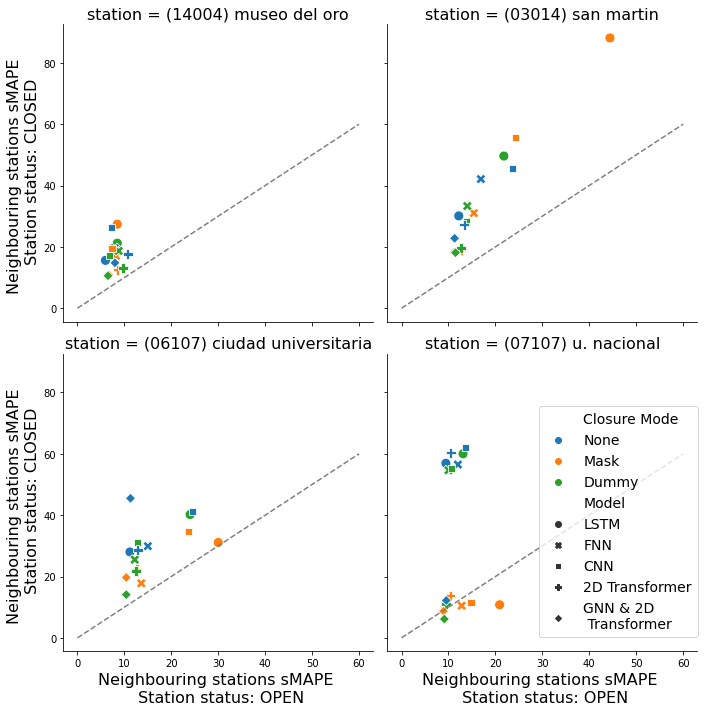

In [7]:
g = sns.relplot(data = results, x = 'all', y = 'close', hue = 'Closure Mode', 
            style = "Model", s = 100, col = "station", col_wrap = 2)

g = (g.set_axis_labels("Neighbouring stations sMAPE \n Station status: OPEN", 
                       "Neighbouring stations sMAPE \n Station status: CLOSED", fontsize = 16)).set_titles(size = 16)

def add_slope_one_line(max_value = 60, **kwargs):
    plt.plot([0, max_value], [0, max_value], color='gray', linestyle='--')
    
g = g.map(add_slope_one_line)

if g._legend:
    g._legend.remove()
legend = g.fig.legend( fontsize=14, loc='lower right', bbox_to_anchor=(0.85, 0.1))
legend.get_frame().set_facecolor('white')

plt.show()

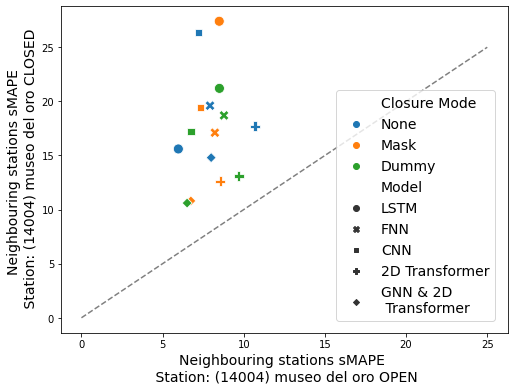

In [8]:
## This plot is just a zoom to the first plot. 

plt.figure(figsize=(8, 6))
sns.scatterplot(data = results.iloc[:15], x = 'all', y = 'close', hue = 'Closure Mode', style = "Model", s = 100)
plt.legend(loc='center left', bbox_to_anchor=(0.60, 0.39), ncol=1, fontsize=14, title_fontsize=16)
plt.ylabel("Neighbouring stations sMAPE \n Station: (14004) museo del oro CLOSED", fontsize = 14)
plt.xlabel("Neighbouring stations sMAPE \n Station: (14004) museo del oro OPEN", fontsize = 14)

plt.plot([0, 25], [0, 25], linestyle='--', color='gray')
plt.show()

# Plot 2 - Differences

**Objective**: Plot all the cases in which a station was close for all stations. 

In the code, for each station, I check weather it has been closed or not. If if has been closed, I check the accuracy of the neigburing stations (as given by the adacency matrix) when the station is open, and when the station is close. 

In [34]:
## Plot for all the case that stations are closed. 

adj_matrix = pd.read_parquet('../../data/adjacency_matrix.parquet')
np.fill_diagonal(adj_matrix.values, 0)

loss_list = []

#Iteration over stations
for station in adj_matrix.index:
    
    close_station = station
    nearby_stations = list(adj_matrix.columns[adj_matrix.loc[station] == 1])

    df_target = filtered_target
    closed = df_target[close_station] == 0
    closed = closed.values

    target_close = df_target[nearby_stations][closed]
    target_open = df_target[nearby_stations][~closed]

    #Iteration Over Predicted Models
    for result in filter_predictions:
        predicted_close = result[nearby_stations][closed]
        predicted_open = result[nearby_stations][~closed]

        #Estimate loss closs
        loss_closed = losses.sMAPE(target_close, predicted_close, axis = None)
        loss_closed = pd.DataFrame(data = {'sMAPE': loss_closed, 
                                          'var' : 'close', 
                                          'Model' : result.model,
                                          'Closure Mode': result.closure_mode,
#                                           'station':nearby_stations, 
                                          'closed_station': close_station}, index = [0])

        #Estimate loss Open
        loss_open = losses.sMAPE(target_open, predicted_open, axis = None)
        loss_open = pd.DataFrame(data = {'sMAPE': loss_open, 
                                          'var' : 'open', 
                                          'Model' : result.model,
                                          'Closure Mode': result.closure_mode,
#                                           'station':nearby_stations, 
                                          'closed_station': close_station}, index = [0])

        loss_list.append(loss_closed)
        loss_list.append(loss_open)
        
final_results = pd.concat(loss_list, axis = 0)
final_results['Closure Mode'] = final_results['Closure Mode'].replace({'mask': 'Mask', 
                                                                       'dummy': 'Dummy', 
                                                                       'mask ': 'Mask'})

models_dict = {'lstm': 'LSTM','fnn': 'FNN', 'cnn': "CNN", 
               'transformer': "2D Transformer", 'gnn':"GNN + \n 2D Transformer"}
final_results['Model'] = final_results['Model'].replace(models_dict)

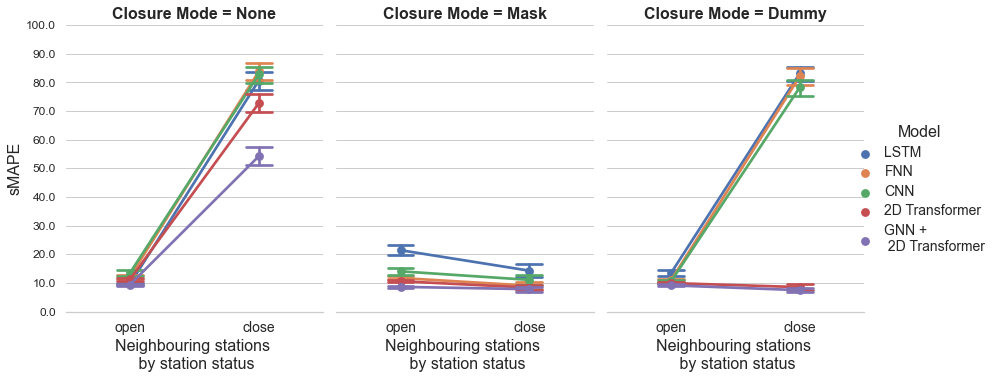

In [35]:
sns.set_theme(style="whitegrid")
g = sns.catplot(data = final_results, x = "var", y = 'sMAPE', col = 'Closure Mode', hue = 'Model', 
            kind="point", height=5, aspect=0.8, capsize=.2, order = ['open','close'])

g.set_axis_labels('Neighbouring stations \n by station status', 'sMAPE', fontsize=16)
g.set_xticklabels(fontsize=14)
g.set_yticklabels(fontsize=14)
g.despine(left=True)

# Set y-axis tick labels
for ax in g.axes.flat:
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=16, fontweight='bold')
    
    
legend = g.fig.legends[0]
for text in legend.texts:
    text.set_fontsize(14)
legend.set_title(legend.get_title().get_text(), prop={'size': 16})

plt.show()

- **Conclusion 1:** When station closure is ignored, the accuracy of the neighboring stations increase substantially, from 10 sMAPE, to at least 50. However the GNN method performs significantly best than the rest. 
- **Conclusion 2:** The masking function greatly redice the gap, maintianing a similar accuracy. The GNN model continues to be the best, but the performance is comparable to other models. LSTM performs significanly worse. 

- **Conclusion 3:** The dummy variable seems to be only relevant for the attention-based models. 

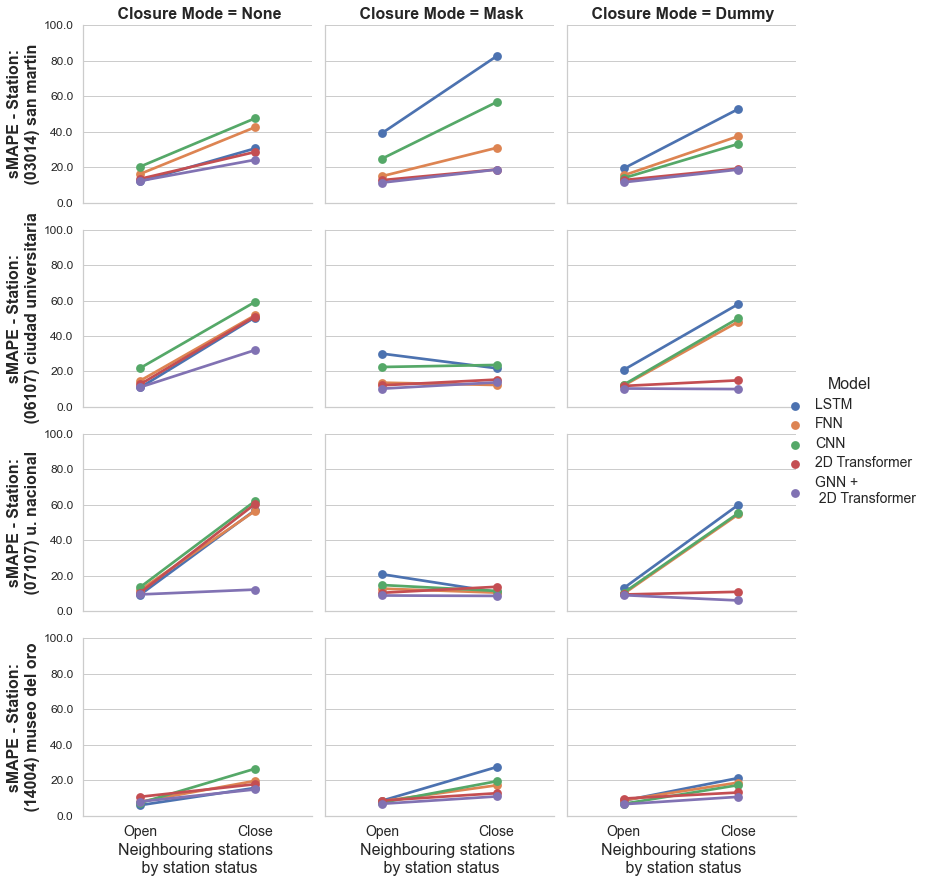

In [36]:
# Same Plot for selected stations

stations = ['(14004) museo del oro', 
            '(03014) san martin',
           '(06107) ciudad universitaria',
           '(07107) u. nacional']

w = final_results[final_results.closed_station.isin(stations)]

sns.set_theme(style="whitegrid")
g = sns.catplot(data = w, x = "var", y = 'sMAPE', col = 'Closure Mode', hue = 'Model', row = 'closed_station',
            kind="point", height=3, aspect=1.2, capsize=.2, order = ['open','close'])

g.set_axis_labels('Neighbouring stations \n by station status', 'sMAPE', fontsize=16)
g.set_xticklabels(fontsize=14)
g.set_yticklabels(fontsize=14)

# Set y-axis tick labels
for i, ax in enumerate(g.axes.flat):
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    
    t = ax.get_title().split("|")
    if i < 3:
        ax.set_title(t[1], fontsize=16, fontweight='bold')
    else:
        ax.set_title("")
    ax.set_ylabel("sMAPE - Station:\n {}".format(t[0][17:]), fontweight='bold')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['Open', 'Close'])
    
    
legend = g.fig.legends[0]
for text in legend.texts:
    text.set_fontsize(14)
legend.set_title(legend.get_title().get_text(), prop={'size': 16})

plt.show()

# Plot 3 - Example station Close

In [55]:
from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

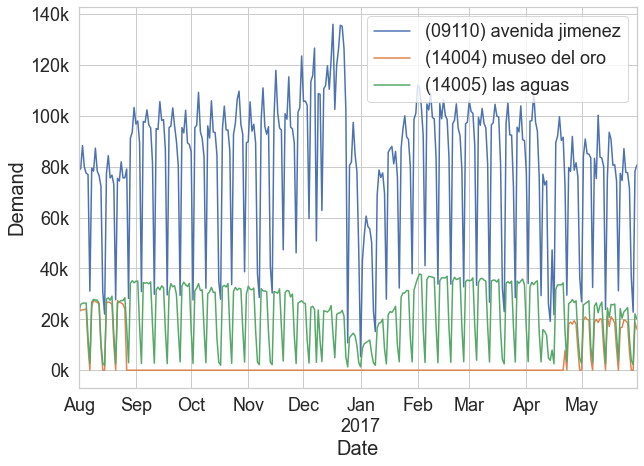

In [75]:
#Example Stations: 
example_stations = ['(09110) avenida jimenez', '(14004) museo del oro', '(14005) las aguas']

daily_demand = target[example_stations].loc['2016-08-01':'2017-05-31'].resample('D').sum()

ax = daily_demand.plot(figsize = (10,7))
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel('Demand', fontsize = 20)
ax.set_xlabel('Date', fontsize = 20)
ax.legend(fontsize=18)
plt.savefig('../../../manuscript/figures/example_station_close.pdf', format='pdf', dpi=300)
plt.show()

# Plot 4 - Distributions of station closures

In [ ]:
def close_periods_lenght(s):
    groups = s.ne(0).cumsum()
    consecutive_zeros = s.groupby(groups).apply(lambda x: (x == 0).sum())
    return consecutive_zeros[consecutive_zeros != 0]

In [105]:
target = data.clean_data('../../data/transactions.parquet')
target = target.iloc[1064:,:-8]
filter_time = (target.index.hour > 5) & (target.index.hour < 22)
df_4 = target[filter_time]
df_4 = (df_4 > 0).astype(int)  # Boolean for station closures

In [236]:
# This Takes a long time to run
# closures_lenght = []
# for column in df_4.columns:
#     r = close_periods_lenght(df_4[column])
#     closures_lenght.append(r)
    
# I saved it, and read it again for future fast processing
# closure_duration = pd.concat(closures_lenght)
# closure_duration.to_csv('closure_duration.csv')

closure_duration = pd.read_csv('closure_duration.csv',  index_col=0)
closure_duration = closure_duration.squeeze()

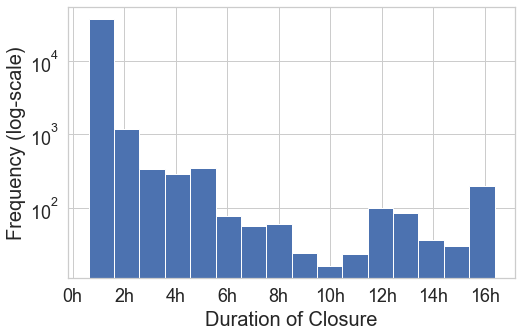

In [239]:
ax = closure_duration[closure_duration.between(1,64)].plot.hist(bins = 16, logy=True, figsize = (8,5))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
plt.xlabel("Duration of Closure", fontsize = 20)
plt.ylabel("Frequency (log-scale)", fontsize = 20)

# set the x-tick positions and labels
xtick_positions = np.arange(0, 65, 8)- 1.5  # every 8 intervals marks 2 hours
xtick_labels = [i + "h" for i in np.arange(0, 17, 2).astype(str)]  # label every other tick position with the hour
plt.xticks(xtick_positions, xtick_labels)
plt.savefig('../../../manuscript/figures/closure_duration_distribution.pdf', format='pdf', dpi=300)
plt.show()

# Plot 5 - What happens with the prediciton when the stations closes? 

Cierre de la estacion Ciudad Universitaria por distrubios. 

Closure for 3:30 hours 

On the news: 
https://www.lafm.com.co/bogota/disturbios-en-la-universidad-nacional-bloquean-la-calle-26

In [372]:
station = '(06107) ciudad universitaria'
date = '2018-08-15'


target = data.clean_data('../../data/transactions.parquet')
target = target.iloc[1064:,:-8]
filter_time = (target.index.hour > 5) & (target.index.hour < 22)
target_df = target[filter_time]

target = target_df[station].loc[date:date]
target = target.reset_index()
print( "Target Shape: {}".format(target.shape))

# Loading Results
experiments = ['1_lstm_None_lstm_predictions.parquet','2_lstm_mask_lstm_predictions.parquet',
               '3_lstm_dummy_lstm_predictions.parquet', '4_fnn_None_fnn_predictions.parquet', 
               '5_fnn_mask_fnn_predictions.parquet', '6_fnn_dummy_fnn_predictions.parquet',
               '7_cnn_None_cnn_predictions.parquet', '8_cnn_mask_cnn_predictions.parquet', 
               '9_cnn_dummy_cnn_predictions.parquet', 
               '10_transformer_None_transformer_predictions.parquet',
               '11_transformer_mask _transformer_predictions.parquet',
               '12_transformer_dummy_transformer_predictions.parquet', 
               '13_gnn_None_gnn_predictions.parquet', 
               '14_gnn_mask _gnn_predictions.parquet',
               '15_gnn_dummy_gnn_predictions.parquet']

filter_predictions = []

for i, exp in enumerate(experiments):
    df = pd.read_parquet('../outputs/{}'.format(exp))
    filter_time = (df.index.hour > 5) & (df.index.hour < 22)
    df = df[filter_time].loc[date:date, [station]] 
    df.name = exp[:11]
    names = exp.split("_")[1:3]
    df['model'] = names[0]
    df['closure_mode'] = names[1]
    filter_predictions.append(df)
    print("Experiment {} shape: {}".format(i+1, df.shape))

Target Shape: (64, 2)
Experiment 1 shape: (64, 3)
Experiment 2 shape: (64, 3)
Experiment 3 shape: (64, 3)
Experiment 4 shape: (64, 3)
Experiment 5 shape: (64, 3)
Experiment 6 shape: (64, 3)
Experiment 7 shape: (64, 3)
Experiment 8 shape: (64, 3)
Experiment 9 shape: (64, 3)
Experiment 10 shape: (64, 3)
Experiment 11 shape: (64, 3)
Experiment 12 shape: (64, 3)
Experiment 13 shape: (64, 3)
Experiment 14 shape: (64, 3)
Experiment 15 shape: (64, 3)


In [404]:
predictions = pd.concat(filter_predictions, axis = 0).reset_index()
predictions.closure_mode = predictions.closure_mode.replace( {'mask':'Mask', 'dummy': 'Dummy', 'mask ':'Mask'})

models_dict = {'lstm': 'LSTM','fnn': 'FNN', 'cnn': "CNN", 
               'transformer': "2D Transformer", 'gnn':"GNN + \n 2D Transformer"}

predictions.model = predictions.model.replace(models_dict)
predictions.rename(columns = {'model': 'Model'}, inplace = True)

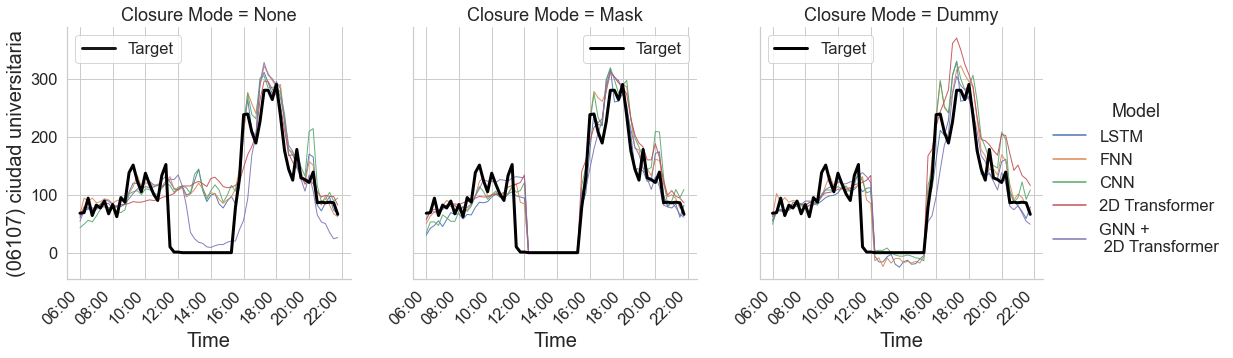

In [416]:
sns.set(font_scale=1.5, style="whitegrid")


g = sns.relplot(data = predictions, x = 'timestamp', y = station, 
            col = 'closure_mode', hue = 'Model', kind = 'line', 
            height=5, aspect=1, alpha = 0.9, linewidth=1)

for i, ax in enumerate(g.axes.flat):
    sns.lineplot(data=target, x='timestamp', y=station, ax=ax, color='black', 
                 label='Target', linewidth=3)
    
    if i == 0:
        legend = ax.legend(labels=['Target'])
        legend.get_lines()[-1].set_linewidth(3)
        legend.get_lines()[0].set_color('black')
    ax.set_title("Closure Mode = {}".format(g.col_names[i]))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate(rotation=45)

plt.subplots_adjust(top=0.9)
plt.gcf().axes[0].set_xlabel('Time', fontsize=20)
plt.gcf().axes[1].set_xlabel('Time', fontsize=20)
plt.gcf().axes[2].set_xlabel('Time', fontsize=20)
plt.gcf().axes[0].set_ylabel(station, fontsize=20)


plt.savefig('../../../manuscript/figures/closures.pdf', format='pdf', dpi=300, facecolor='white')

plt.show()

# Plot 6 - Attention Plots

In [611]:
import tensorflow as tf
import itertools

In [612]:
# Load the model 
model_path = '../outputs/14_gnn_mask _gnn_model'
model = tf.saved_model.load(model_path)

#Prepare data for simulation 
transactions_path = '../../data/transactions.parquet'
stations_path = '../../data/stations_DB.parquet'
adj_path = '../../data/adjacency_matrix.parquet'
aggregation = "15-mins"
# train_date = '2018-08-01'
train_date = '2015-08-20'
max_transactions = '1500'
max_stations = None

train_data, test_data, adj_matrix, metadata = data.tf_data(
        transactions_path,
        stations_path,
        adj_path,
        aggregation,
        train_date,
        max_transactions,
        max_stations)

# Organize Model Inputs
train_date_index = metadata['train_date_index']
train_features = train_data['features']
train_time_embeddings = train_data['time_embeddings']
train_spatial_embeddings = train_data['spatial_embeddings']
train_status = train_data['status']

# Estimate Predictions and attentions 
predictions, attention = model(train_features, train_time_embeddings, train_spatial_embeddings, train_status)


Train features shape: (378, 18, 147)
Test features shape: (58, 18, 147)

Train time_embeddings shape: (378, 19, 8)
Test time_embeddings shape: (58, 19, 8)

Train spatial_embeddings shape: (378, 147, 2)
Test spatial_embeddings shape: (58, 147, 2)

Train labels shape: (378, 147)
Test labels shape: (58, 147)

Train status shape: (378, 19, 147)
Test status shape: (58, 19, 147)

Adj Matrix Shape: (1, 147, 18, 147)


#### Generating The Attention Plots 

In [613]:
# General Information 
obsertation_idx = 300
station = '(02000) cabecera autopista norte'
station = '(14004) museo del oro'

station_index = metadata['list_stations'].index(station)
indxs = np.array(np.nonzero(adj_matrix[0,station_index,0])).flatten().tolist()
station_names = [metadata['list_stations'][i] for i in indxs]
attention_matrix = np.array(attention[obsertation_idx])

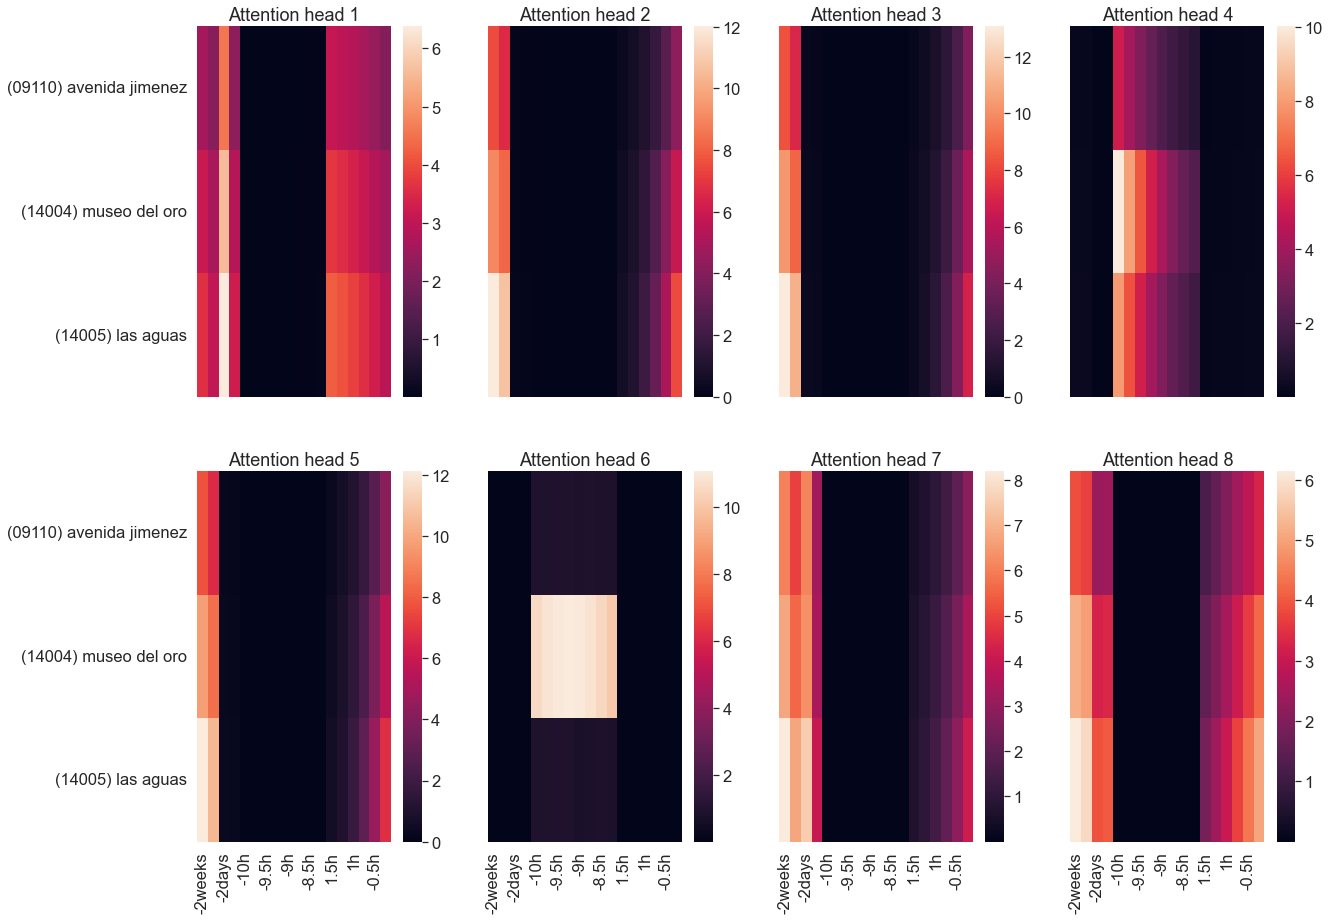

In [614]:
# Plotting 8 heads 
yticklabels = station_names
xticklabels = ['-2weeks', '-2days', '-10h', '-9.5h', 
               '-9h' , '-8.5h','1.5h','1h','-0.5h']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))

for i in range(2):
    for j in range(4):
        sns.heatmap(attention_matrix[i*4+j,0,station_index,:,indxs] * 100,
                    annot=False, ax=axes[i,j])
        axes[i,j].set_title(f"Attention head {i*4+j+1}")
        
        if j == 0:
            axes[i,j].set_yticklabels(yticklabels, rotation = 0)
        else:
            axes[i,j].set_yticklabels([])
        if i > 0:
            axes[i,j].set_xticklabels(xticklabels, rotation = 90)
        else:
            axes[i,j].set_xticklabels([])

plt.savefig('../../../manuscript/figures/attention_plots_8_heads.pdf', format='pdf', dpi=300, facecolor='white')
plt.show()

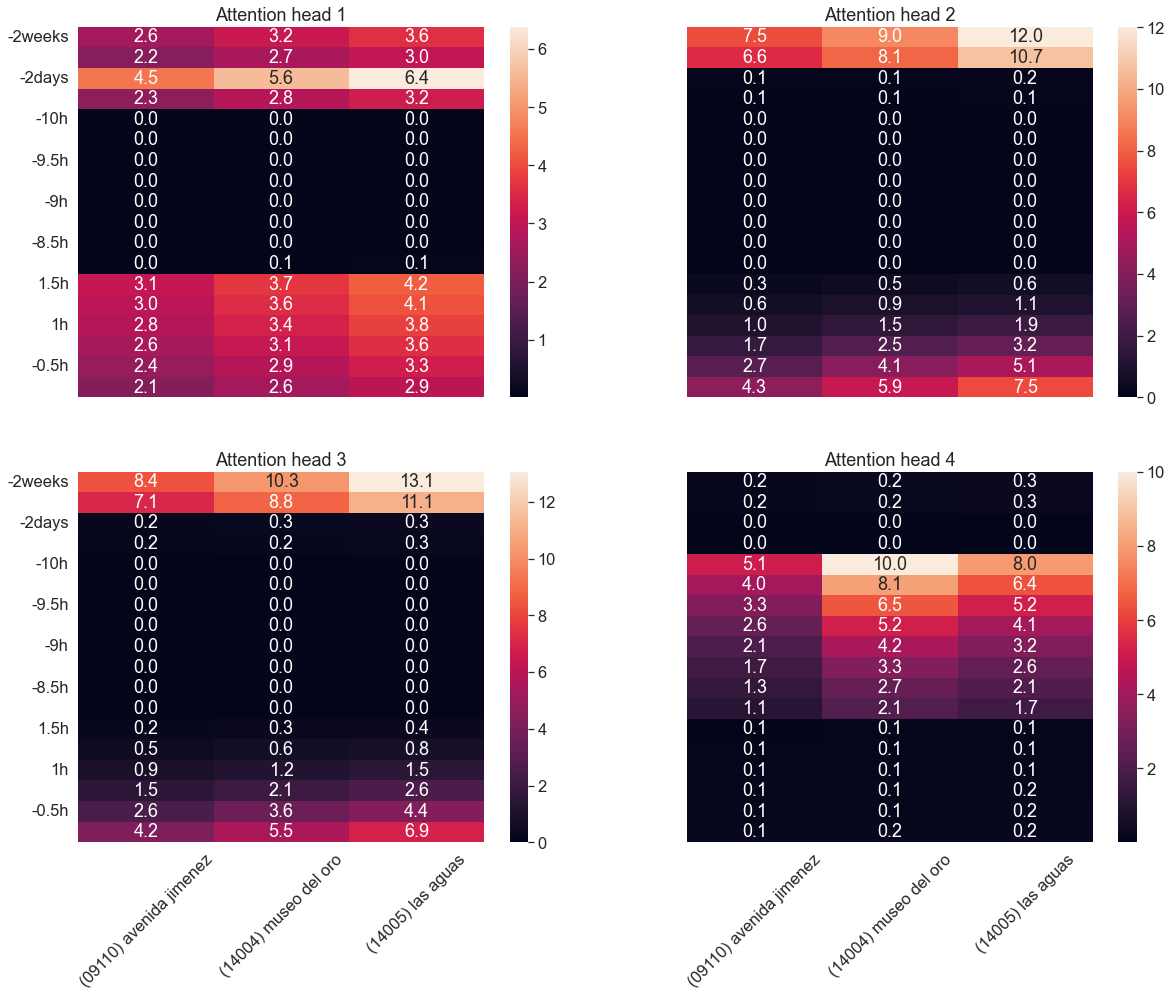

In [615]:
#Plotting 4 head only 

xticklabels = station_names
yticklabels = ['-2weeks', '' , '-2days', '', '-10h', '', '-9.5h', '', 
               '-9h' , '', '-8.5h', '','1.5h', '','1h', '','-0.5h', '']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

combinations = itertools.product(range(2), range(2))

for pos, (i, j) in enumerate(combinations):
    sns.heatmap(attention_matrix[pos,0,station_index,:,indxs].T * 100,
                    annot=True, fmt=".1f", ax=axes[i,j], )
    axes[i,j].set_title(f"Attention head {pos+1}")
    
    if j == 0:
        axes[i,j].set_yticklabels(yticklabels, rotation = 0)
    else:
        axes[i,j].set_yticklabels([])
    if i > 0:
        axes[i,j].set_xticklabels(xticklabels, rotation = 45)
    else:
        axes[i,j].set_xticklabels([])

plt.savefig('../../../manuscript/figures/attention_plots_4_heads.pdf', format='pdf', dpi=300, facecolor='white')

plt.show()